In [1]:
import pandas as pd
import numpy as np
import glob,os,re,string
import pytz
import datetime
import pymongo
import re
import pandas as pd
from datetime import timedelta
from opencc import OpenCC

In [ ]:
try:
    # password authentication to login to MongoDB
    client = pymongo.MongoClient(
        host='xxxx',
        port='xxxx'
    )
    # access Openup Database and authenticate
    db = client['OpenupDB']

except:
    print('Cannot access OpenUp database.')
    if client:
        client.close()
        
def conversation_extractor(start_time, end_time):
    ...

def history_extractor(conversationId_list):
    ...

In [ ]:
db_name = input('Please input the database you want to get: ')

if db_name == 'Conversation':
    start_time = input('Please input the start time: ')
    end_time = input('Please input the end time: ')
    ...
    valid_cs = conversation_extractor(start_time, end_time)
    ...
    conversationId_list = valid_cs['uuid'].unique().tolist()
    ...
    chat_history = history_extractor(conversationId_list)
    ...

In [7]:
valid_cs.shape

(117072, 44)

In [6]:
chat_history.shape

(9390973, 7)

In [ ]:
print('The count of valid conversations from %s to %s: %s'%(valid_cs['startDateTime'].min(), valid_cs['startDateTime'].max(), len(valid_cs))
print('The count of messages from %s to %s: %s'%(chat_history['datetime'].min(), chat_history['datetime'].max(), len(chat_history))

In [14]:
df_msg = chat_history.copy()

# word2vec training

In [2]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import jieba
from pycantonese.word_segmentation import Segmenter
import pycantonese

In [9]:
# load self-defined tokenization dictionary
jieba.set_dictionary('../data/tokenization_dict/dict.txt')
jieba.load_userdict('../data/tokenization_dict/hk_dict.txt')

Building prefix dict from C:\Users\Harrison\Documents\HKU\paper\GPT_sentiment_analysis\supplementary_material\data\tokenization_dict\dict.txt ...
Loading model from cache C:\Users\Harrison\AppData\Local\Temp\jieba.uca32d7fd4479c948cd6f929a868b2453.cache
Loading model cost 0.885 seconds.
Prefix dict has been built successfully.


In [10]:
list(jieba.cut('這次上黎想傾d咩 你可以試下聯繫平行心間夜貓和風雨蘭'))

['這次',
 '上黎想',
 '傾',
 'd',
 '咩',
 ' ',
 '你',
 '可以',
 '試下',
 '聯繫',
 '平行心間',
 '夜貓',
 '和',
 '風雨蘭']

In [12]:
# stopwords
stop_words=['乜','個','嗰','吖','啦','又','呀','咗','咁','呢','咩','哦','哩','啲','啊','喎','嗯','噢','喔',
            '果','係','左','先','架','㗎','噶','嘎','嘅','既','嘢','噉','即','同','都','有','冇','的','黎','嚟',
            '啦', '啵', '喺', '嗱', '嘅', '噃', '咁', '噉', '噓', '唔', '嘛', '咩', '嘢', '啊', '嗚', '嘻', '啫',
            '啱', '添', '喇', '甘', '咯', '啊']

cn_stopwords=list(pd.read_csv("../data/stopwords/cn_stopwords.txt").to_numpy().squeeze())
scu_stopwords=list(pd.read_csv("../data/stopwords/scu_stopwords.txt").to_numpy().squeeze())
traditional_cn_stopwords = []
traditional_scu_stopwords = []
converter = OpenCC('s2hk.json')
for i in range(len(cn_stopwords)):
    traditional_cn_stopwords.append(converter.convert(cn_stopwords[i]))
for i in range(len(scu_stopwords)):
    traditional_scu_stopwords.append(converter.convert(scu_stopwords[i]))
    
pycantonese_stopwords=list(pycantonese.stop_words())

stop_words_total = stop_words + traditional_cn_stopwords + traditional_scu_stopwords + pycantonese_stopwords

In [ ]:
# tokenization
speech_list = list(df_msg['msg'])
rule = re.compile(r"[^\u4e00-\u9fa5]")
speech_list = [list(jieba.cut(rule.sub('', speech))) for speech in speech_list]
speech_list

In [ ]:
# remove stopwords
for idx, speech in enumerate(speech_list):
    speech_list[idx] = ' '.join([word for word in speech if word.strip() not in stop_words_total])

df_msg['msg_token'] = speech_list
df_msg

In [ ]:
df_msg['msg_token_list'] = [i.split(' ') for i in df_msg['msg_token']]
df_msg_valid = df_msg[(df_msg['msg_token_list'].map(len)>=1) & (df_msg['msg_token'] != '')]
df_msg_valid

In [18]:
df_msg_valid.reset_index(inplace=True,drop=True)

In [ ]:
# remove words that contains stop words
df_msg_valid['msg_token_list'] = [[word for word in sub_list if not any(stop in word for stop in stop_words)] for sub_list in df_msg_valid['msg_token_list']]
# remove single character
df_msg_valid['msg_token_list'] = [[word for word in sub_list if len(word) > 1] for sub_list in df_msg_valid['msg_token_list']]
df_msg_valid

In [ ]:
df_msg_valid['msg_token'] = [' '.join(i) for i in df_msg_valid['msg_token_list']]
df_msg_valid = df_msg_valid[(df_msg_valid['msg_token_list'].map(len)>=1) & (df_msg_valid['msg_token'] != '')]
df_msg_valid

In [21]:
print('Message count Before filteriing: %s \nMessage count After filteriing: %s'%(df_msg.shape[0], df_msg_valid.shape[0]))

Message count Before filteriing: 9390973 
Message count After filteriing: 7012611


In [ ]:
word2vec_token = df_msg_valid['msg_token'].tolist()
word2vec_token

In [23]:
len(word2vec_token)

7012611

In [ ]:
word2vec_token_list = df_msg_valid['msg_token_list'].tolist()
word2vec_token_list

In [3]:
from gensim.models import Word2Vec

In [25]:
model = Word2Vec(sentences=word2vec_token_list, vector_size=100, window=5, min_count=5, workers=4)
model.train(word2vec_token_list, total_examples=len(word2vec_token_list), epochs=10)

(253807903, 284799090)

In [26]:
model.wv.most_similar(positive=['瞓覺'])

[('訓覺', 0.8842084407806396),
 ('訓教', 0.8250408172607422),
 ('就訓', 0.763026237487793),
 ('夜瞓', 0.7449564933776855),
 ('熄燈', 0.7246344089508057),
 ('床度', 0.7245703935623169),
 ('晏覺', 0.7179387211799622),
 ('一訓', 0.7130290269851685),
 ('我訓', 0.7108752131462097),
 ('訓但', 0.7095429301261902)]

In [27]:
model.save('../word2vec_embedding/openup_word2vec_20231001.model')
model.wv.save_word2vec_format('../word2vec_embedding/openup_word2vec_20231001.vector',binary=False)

# word2vec illustration

In [4]:
model = Word2Vec.load('../word2vec_embedding/openup_word2vec_20231001.model')

In [5]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, init='pca', n_iter=1000)

vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
embed_two = tsne.fit_transform(X)

labels = model.wv.index_to_key

In [84]:
df_embed = pd.DataFrame(embed_two, index=labels)

In [85]:
#df_embed.to_excel('../word2vec_embedding/pca_2_dimension.xlsx', index=True)

In [59]:
pos = ["幸福", "自在", "輕鬆", "熱情", '希望', '勇敢', '正面', '尊重', '包容']
neg = ['緊張', '崩潰', '自殺', '躁鬱', '跳樓', '嚇親', '胡思亂想', '不適', '好痛', '安眠藥']
neu = ['輔導員', '服務', '之前', '發送', '學校', '升學', '公司', '青少年', '查詢', '介紹']

In [60]:
word_display_list = pos+neg+neu

In [80]:
translations = {
    "幸福": "幸福 (happy)",
    "自在": "自在 (comfortable)",
    "輕鬆": "輕鬆 (relaxed)",
    "熱情": "熱情 (passionate)",
    "希望": "希望 (hope)",
    "勇敢": "勇敢 (brave)",
    "正面": "正面 (positive)",
    "尊重": "尊重 (respect)",
    "包容": "包容 (inclusive)",
    "緊張": "緊張 (nervous)",
    "崩潰": "崩潰 (breakdown)",
    "自殺": "自殺 (suicide)",
    "躁鬱": "躁鬱 (bipolar disorder)",
    "跳樓": "跳樓 (jump off a building)",
    "嚇親": "嚇親 (scared)",
    "胡思亂想": "胡思亂想 (overthinking)",
    "不適": "不適 (unwell)",
    "好痛": "好痛 (very painful)",
    "安眠藥": "安眠藥 (sleeping pills)",
    "輔導員": "輔導員 (counselor)",
    "服務": "服務 (service)",
    "之前": "之前 (before)",
    "發送": "發送 (send)",
    "學校": "學校 (school)",
    "升學": "升學 (further study)",
    "公司": "公司 (company)",
    "青少年": "青少年 (teenager)",
    "查詢": "查詢 (inquiry)",
    "介紹": "介紹 (introduction)"
}

In [61]:
# display chinese chars
import matplotlib as mpl
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
mpl.rcParams['axes.unicode_minus']=False

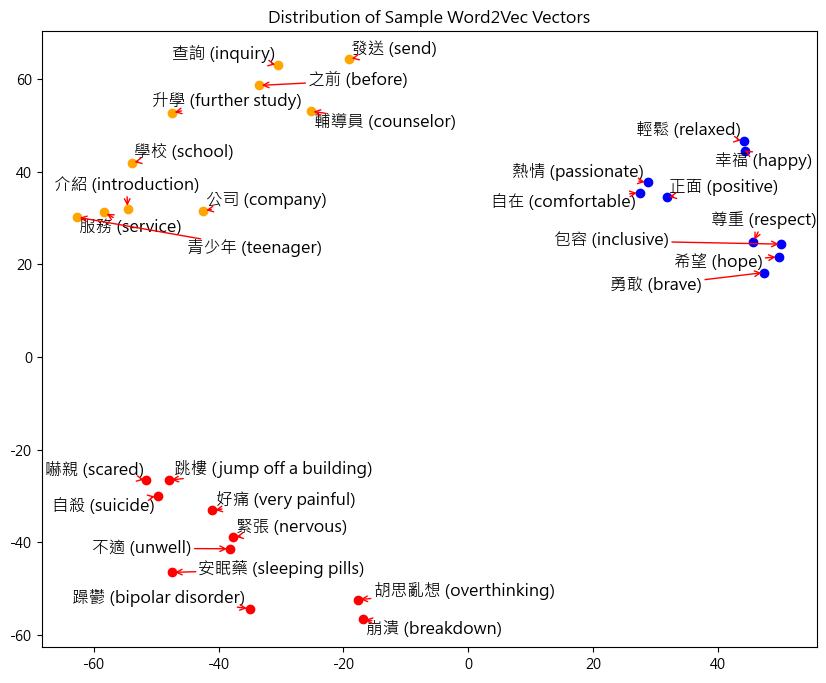

In [83]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

plt.figure(figsize=(10, 8))

texts = []
for label in word_display_list:
    x, y = embed_two[labels.index(label)]
    
    if label in pos:
        color = 'blue'
    elif label in neg:
        color = 'red'
    elif label in neu:
        color = 'orange'
        
    plt.scatter(x, y, color = color)
    
    trans_label = translations[label]

    texts.append(plt.text(x, y, trans_label, ha='left', va='center', fontsize=12))

adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

plt.title("Distribution of Sample Word2Vec Vectors")
plt.show()

In [88]:
len(labels)

70951